In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
from pyspark.sql.types import StructType, ArrayType
from pyspark.sql import functions as F
from helper import (
    read_sql_file, 
    plot_multiple_line_graphs2,
    thousands_formatter,
    millions_formatter,
    billions_formatter,
    trillions_formatter,
)
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Big Data And Cloud Computing Laboratory Report

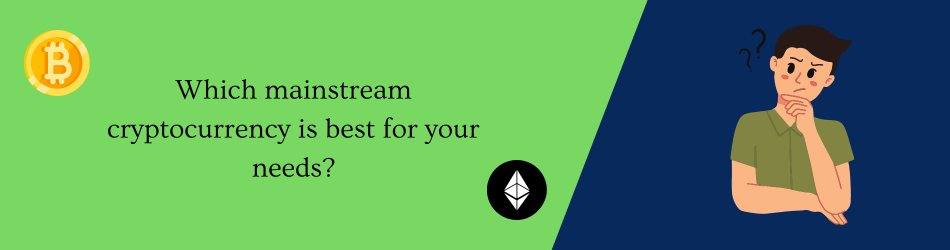

## EXECUTIVE SUMMARY

This executive summary evaluates the decision-making process for choosing between Bitcoin (BTC) and Ethereum (ETH) by analyzing their practical use cases and key performance metrics. Bitcoin is primarily regarded as a digital store of value and a medium of exchange, while Ethereum empowers decentralized applications (dApps) and smart contracts, playing a crucial role in the Web3 ecosystem.

Through an exploratory data analysis (EDA), we examine essential factors such as total and average transaction values, transaction fees, transaction volumes, throughput, transaction speed, supply dynamics, and the Network Value to Transactions (NVT) ratio. These metrics provide valuable insights into the operational efficiency and economic utility of each cryptocurrency.

By understanding these critical elements, users can make informed decisions about which mainstream cryptocurrency best aligns with their specific needs, effectively balancing transaction efficiency, cost-effectiveness, and overall utility in the rapidly evolving digital economy.

## INTRODUCTION

Ethereum (ETH), the second-largest cryptocurrency by market capitalization after Bitcoin (BTC), serves a different purpose in the crypto ecosystem. While both are traded on exchanges and stored in wallets, Bitcoin is primarily designed as an alternative to fiat currency. Ethereum, on the other hand, supports complex smart contracts and decentralized applications, playing a critical role in Web3 infrastructure.

**Key Differences**  
- **Consensus Mechanism**: Bitcoin uses Proof of Work (PoW), relying on miners to validate transactions. In contrast, Ethereum shifted to Proof of Stake (PoS) in 2022, where validators stake ETH to secure the network, making it more energy-efficient and sustainable.  
- **Purpose**: Bitcoin acts as a store of value and digital currency, whereas Ethereum powers not only its currency but also decentralized applications and smart contracts.

## Blockchain Dataset

The AWS Public Blockchain Data provide datasets from the Bitcoin and Ethereum blockchains. The blockchain data is transformed into multiple tables as compressed Parquet files partitioned by date to allow efficient access for most common analytics queries. In this project we read and analyze the public dataset in Jojie.

### Create Spark Session 

In [2]:
spark = SparkSession.builder.appName("BDCCLab").master("local[*]").getOrCreate()

In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

### Show Raw Data Size 

In [4]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/

901G	/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/


In [5]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/eth/blocks/

14G	/mnt/data/public/aws-public-blockchain/v1.0/eth/blocks/


In [6]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/

1.5T	/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/


In [7]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/btc/blocks/

331M	/mnt/data/public/aws-public-blockchain/v1.0/btc/blocks/


### Read Raw Data

In [8]:
df_eth_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/")

In [9]:
df_eth_blocks = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/blocks/")

In [10]:
df_btc_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/")

In [11]:
df_btc_blocks = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/blocks/")

### ETH Transactions Schema

In [12]:
df_eth_trans.printSchema()

root
 |-- gas: long (nullable = true)
 |-- hash: string (nullable = true)
 |-- input: string (nullable = true)
 |-- nonce: long (nullable = true)
 |-- value: double (nullable = true)
 |-- block_number: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- transaction_index: long (nullable = true)
 |-- from_address: string (nullable = true)
 |-- to_address: string (nullable = true)
 |-- gas_price: long (nullable = true)
 |-- receipt_cumulative_gas_used: long (nullable = true)
 |-- receipt_gas_used: long (nullable = true)
 |-- receipt_contract_address: string (nullable = true)
 |-- receipt_status: long (nullable = true)
 |-- receipt_effective_gas_price: long (nullable = true)
 |-- transaction_type: long (nullable = true)
 |-- max_fee_per_gas: long (nullable = true)
 |-- max_priority_fee_per_gas: long (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for ETH transactions<sup>2</sup>. `gas` and `value` are the notable fields which is measured in <b>WEI (1 ETH = 1E18 WEI)</b>
Field | Type | Description 
--- | --- | ---
date | string | Partition column (YYYY-MM-DD)
hash | string | Hash of the transaction
nonce | bigint | The number of transactions made by the sender prior to this one
transaction_index | bigint | Integer of the transactions index position in the block
from_address | string | Address of the sender
to_address | string | Address of the receiver
value | double | Value transferred in wei      
gas | bigint | Gas price provided by the sender in wei       
gas_price | bigint | Gas provided by the sender
input | string | The data sent along with the transaction
receipt_cumulative_gas_used | bigint | The total amount of gas used when this transaction was executed in the block
receipt_gas_used | bigint | The amount of gas used by this specific transaction alone
receipt_contract_address | string | The contract address created, if the transaction was a contract creation
receipt_status | bigint | If the transaction was successful
block_timestamp | timestamp | The unix timestamp for when the block was collated
block_number | bigint | Block number where this transaction was in
block_hash | string | Hash of the block
max_fee_per_gas | bigint | Total fee that covers both base and priority fees
max_priority_fee_per_gas | bigint | Fee given to miners to incentivize them to include the transaction
transaction_type | bigint | Transaction type
receipt_effective_gas_price | bigint | The actual value per gas deducted from the senders account.

### ETH Blocks Schema

In [13]:
df_eth_blocks.printSchema()

root
 |-- difficulty: double (nullable = true)
 |-- hash: string (nullable = true)
 |-- miner: string (nullable = true)
 |-- nonce: string (nullable = true)
 |-- number: long (nullable = true)
 |-- size: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- total_difficulty: double (nullable = true)
 |-- base_fee_per_gas: long (nullable = true)
 |-- gas_limit: long (nullable = true)
 |-- gas_used: long (nullable = true)
 |-- extra_data: string (nullable = true)
 |-- logs_bloom: string (nullable = true)
 |-- parent_hash: string (nullable = true)
 |-- state_root: string (nullable = true)
 |-- receipts_root: string (nullable = true)
 |-- transactions_root: string (nullable = true)
 |-- sha3_uncles: string (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- date: date (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for ETH blocks<sup>2</sup>  

Field | Type | Description 
--- | --- | ---
date | string | Partition column (YYYY-MM-DD)
timestamp | timestamp | The unix timestamp for when the block was collated
number | bigint | The block number
hash | string | Hash of the block
parent_hash | string | Hash of the parent block
nonce | string | Hash of the generated proof-of-work
sha3_uncles | string | SHA3 of the uncles data in the block
logs_bloom | string | The bloom filter for the logs of the block
transactions_root | string | The root of the transaction trie of the block
state_root | string | The root of the final state trie of the block
receipts_root | string | The root of the receipts trie of the block
miner | string | The address of the beneficiary to whom the mining rewards were given
difficulty | double | Difficulty for this block
total_difficulty | double | Total difficulty of the chain until this block
size | bigint | The size of this block in bytes
extra_data | string | The “extra data” field of this block
gas_limit | bigint | The maximum gas allowed in this block
gas_used | bigint | The total used gas by all transactions in this block
transaction_count | bigint | Number of transactions in this block
base_fee_per_gas | bigint | Minimum to be charged to send a transaction on the network

### BTC Transactions Schema

In [14]:
df_btc_trans.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- size: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- block_number: long (nullable = true)
 |-- virtual_size: long (nullable = true)
 |-- lock_time: long (nullable = true)
 |-- input_count: long (nullable = true)
 |-- output_count: long (nullable = true)
 |-- is_coinbase: boolean (nullable = true)
 |-- output_value: double (nullable = true)
 |-- outputs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- required_signatures: long (nullable = true)
 |    |    |-- script_asm: string (nullable = true)
 |    |    |-- script_hex: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- value: double (nullable = true)
 |    |    |-- address: string (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- index: long (nullable = tru

Data Dictionary for BTC transactions<sup>3</sup>. `input_value` and `fee` is measured in BTC

Field | Nested Field | Type | Description 
--- | --- | --- | ---
date | | string | Partition column (YYYY-MM-DD)
hash | | string | The hash of this transaction
size | | bigint | The size of this transaction in bytes
virtual_size | | bigint | The virtual transaction size (differs from size for witness transactions)
version | | bigint | Protocol version specified in block which contained this transaction
lock_time | | bigint | Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest block of the blockchain
block_hash | | string | Hash of the block which contains this transaction
block_number | | bigint | Number of the block which contains this transaction
block_timestamp | | timestamp | Timestamp of the block which contains this transaction
index | | bigint | The index of the transaction in the block
input_count | | bigint | The number of inputs in the transaction
output_count | | bigint | The number of outputs in the transaction
input_value | | double | Total value of inputs in the transaction (in BTC)
output_value | | double | Total value of outputs in the transaction (in BTC)
is_coinbase | | boolean | True if this transaction is a coinbase transaction
fee | | double | The fee paid by this transaction
inputs | | array | Transaction inputs
inputs | index | bigint | 0 indexed number of an input within a transaction
inputs | spent_transaction_hash | string | The hash of the transaction which contains the output that this input spends
inputs | spent_output_index | bigint | The index of the output this input spends
inputs | script_asm | string | Symbolic representation of the bitcoins script language op-codes
inputs | script_hex | string | Hexadecimal representation of the bitcoins script language op-codes
inputs | sequence | bigint | A number intended to allow unconfirmed time-locked transactions to be updated before being finalized; not currently used except to disable locktime in a transaction
inputs | required_signatures | bigint | The number of signatures required to authorize the spent output
inputs | type | string | The address type of the spent output
inputs | address | string | Address which owns the spent output
inputs | value | double | The value in BTC attached to the spent output
outputs | | array | Transaction outputs
outputs | index | bigint | 0 indexed number of an output within a transaction used by a later transaction to refer to that specific output
outputs | script_asm | string | Symbolic representation of the bitcoins script language op-codes
outputs | script_hex | string | Hexadecimal representation of the bitcoins script language op-codes
outputs | required_signatures | bigint | The number of signatures required to authorize spending of this output
outputs | type | string | The address type of the output
outputs | address | string | Address which owns this output
outputs | value | double | The value in BTC attached to this output

### BTC Blocks Schema

In [15]:
df_btc_blocks.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- mediantime: timestamp (nullable = true)
 |-- nonce: long (nullable = true)
 |-- bits: string (nullable = true)
 |-- difficulty: double (nullable = true)
 |-- chainwork: string (nullable = true)
 |-- size: long (nullable = true)
 |-- weight: long (nullable = true)
 |-- coinbase_param: string (nullable = true)
 |-- number: long (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- merkle_root: string (nullable = true)
 |-- stripped_size: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- previousblockhash: string (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for BTC blocks <sup>3</sup>

| Field             | Type      | Description                                                |
|-------------------|-----------|------------------------------------------------------------|
| date              | string    | Partition column (YYYY-MM-DD)                              |
| hash              | string    | Hash of this block                                         |
| size              | bigint    | The size of block data in bytes                            |
| stripped_size     | bigint    | The size of block data in bytes excluding witness data     |
| weight            | bigint    | Three times the base size plus the total size              |
| number            | bigint    | The number of the block                                    |
| version           | int       | Protocol version specified in block header                 |
| merkle_root       | string    | The root node of a Merkle tree, where leaves are transaction hashes |
| timestamp         | timestamp | Block creation timestamp specified in block header         |
| nonce             | bigint    | Difficulty solution specified in block header              |
| bits              | string    | Difficulty threshold specified in block header             |
| coinbase_param    | string    | Data specified in the coinbase transaction of this block   |
| transaction_count | bigint    | Number of transactions included in this block              |
| mediantime        | timestamp |                                                            |
| difficulty        | double    |                                                            |
| chainwork         | string    |                                                            |
| previousblockhash | string    |                                                            |

### Register Temporary Views

In [16]:
df_eth_trans.createOrReplaceTempView("df_eth_trans")
df_eth_blocks.createOrReplaceTempView("df_eth_blocks")
df_btc_trans.createOrReplaceTempView("df_btc_trans")
df_btc_blocks.createOrReplaceTempView("df_btc_blocks")

### Read Coingecko API Historical Daily Prices of BTC and ETH

CoinGecko is a trusted data source for tracking cryptocurrency prices, including Bitcoin (BTC) and Ethereum (ETH). It aggregates data from multiple exchanges, providing real-time price updates, historical charts, and key metrics like market capitalization and trading volume. Its user-friendly interface and commitment to transparency make CoinGecko an essential tool for investors and traders seeking accurate market insights.

In [22]:
eth_prices = spark.read.csv("crypto_prices/eth-usd-max.csv", header=True)
btc_prices = spark.read.csv("crypto_prices/btc-usd-max.csv", header=True)
eth_prices.createOrReplaceTempView("eth_prices")
btc_prices.createOrReplaceTempView("btc_prices")

## Exploratory Data Analysis

### BTC and ETH Comparisons on Count and Total and Average Value and Fees

In [17]:
eth_tot_trans = spark.sql(read_sql_file("sql/eth_tot_trans.sql")).toPandas()
eth_tot_trans

,year,total_value,total_gas,avg_value,avg_gas,total_transactions
0,2015,9.184474e+07,0.066232,87.781841,6.330245e-08,1046284
1,2016,6.625570e+08,0.409877,48.499609,3.000327e-08,13661080
2,2017,4.353256e+09,2.557807,42.288832,2.484730e-08,102941034
3,2018,1.142012e+09,5.449470,4.546831,2.169664e-08,251166529
4,2019,7.653053e+08,3.824180,3.151582,1.574825e-08,242832115
5,2020,9.428725e+08,23.000077,2.734811,6.671195e-08,344766970
6,2021,9.920981e+08,47.371433,2.148294,1.025783e-07,461807363
7,2022,6.946280e+08,19.230624,1.700256,4.707121e-08,408543268
8,2023,4.534225e+08,12.622046,1.183560,3.294708e-08,383100651
9,2024,1.851720e+08,4.934517,1.192735,3.178433e-08,155249958


In [39]:
btc_tot_trans = spark.sql(read_sql_file("sql/btc_tot_trans.sql")).toPandas()
btc_tot_trans

,year,avg_value,avg_fee,total_value,total_fee,total_transactions
0,2009,230.000000,0.000000,1.150000e+03,0.000000,32709
1,2010,134.682635,0.000229,1.271040e+07,21.591013,185305
2,2011,160.148884,0.001676,2.948767e+08,3086.340796,1901765
3,2012,109.886395,0.000811,9.168147e+08,6766.706688,8453050
4,2013,21.875829,0.000780,4.283245e+08,15274.635981,19643241
5,2014,10.422027,0.000184,2.626857e+08,4636.574089,25263720
6,2015,11.955067,0.000180,5.391198e+08,8109.502888,45674023
7,2016,12.927879,0.000273,1.067038e+09,22548.383140,82626623
8,2017,8.960290,0.000965,9.319356e+08,100370.686083,104063229
9,2018,5.174042,0.000315,4.196391e+08,25544.523016,81395636


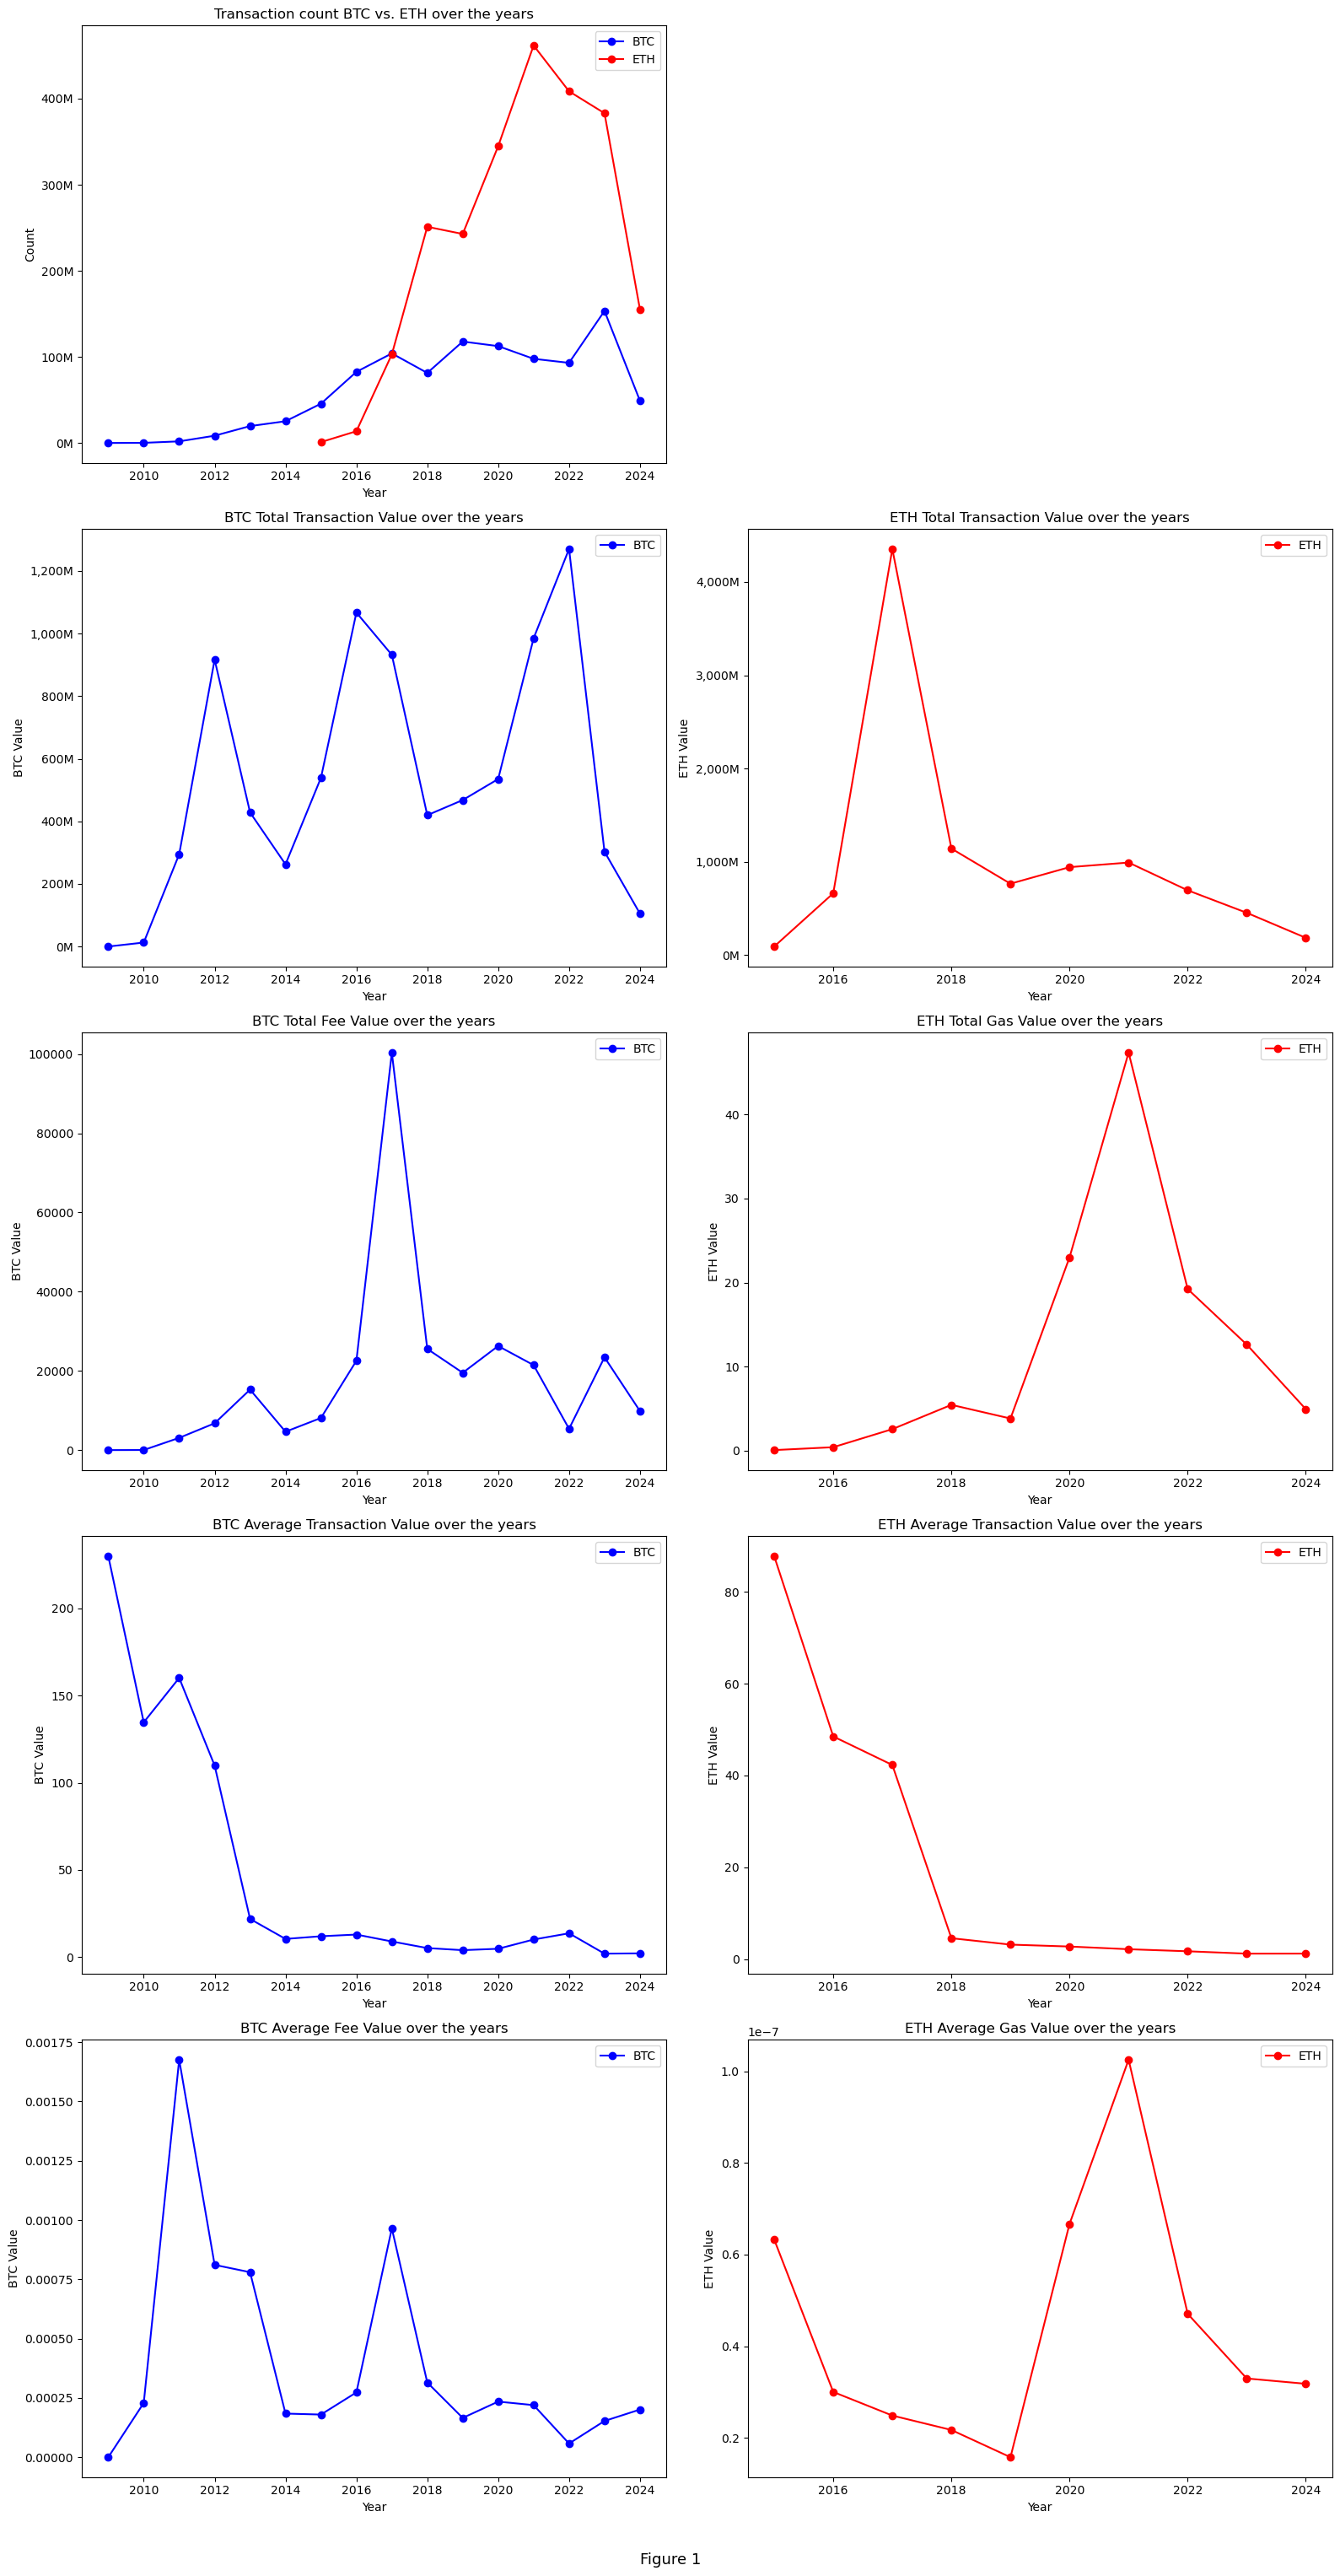

In [40]:
plot_multiple_line_graphs2(
    x_list=[[btc_tot_trans["year"], eth_tot_trans["year"]], None,] + [btc_tot_trans["year"], eth_tot_trans["year"]] * 4,
    y_list=[
        [
            (btc_tot_trans["total_transactions"], "BTC", "b"),
            (eth_tot_trans["total_transactions"], "ETH", "r"),
        ],
        [],
        (btc_tot_trans["total_value"], "BTC", "b"), 
        (eth_tot_trans["total_value"], "ETH", "r"),
        (btc_tot_trans["total_fee"], "BTC", "b"), 
        (eth_tot_trans["total_gas"], "ETH", "r"),
        (btc_tot_trans["avg_value"], "BTC", "b"),
        (eth_tot_trans["avg_value"], "ETH", "r"),
        (btc_tot_trans["avg_fee"], "BTC", "b"), 
        (eth_tot_trans["avg_gas"], "ETH", "r"),
    ],
    x_labels=["Year",] * 10,
    y_labels=["Count", "",] + ["BTC Value", "ETH Value"]*4,
    titles=[
        "Transaction count BTC vs. ETH over the years", 
        "", 
        "BTC Total Transaction Value over the years", 
        "ETH Total Transaction Value over the years", 
        "BTC Total Fee Value over the years", 
        "ETH Total Gas Value over the years", 
        "BTC Average Transaction Value over the years", 
        "ETH Average Transaction Value over the years", 
        "BTC Average Fee Value over the years", 
        "ETH Average Gas Value over the years", 
    ],
    # use_k=[True] + [False] * 9,
    formatter=[millions_formatter, None] + [millions_formatter]*2 + [None]*2 + [None]*2 + [None]*2,
    use_legend=[True] * 10,
    show_grid=False,
    max_cols=2,
    start_figure_number=1
)

**Transaction Count**

The Ethereum blockchain hosts a significantly higher number of transactions compared to Bitcoin. Ethereum's transaction count peaked at approximately 400 million in 2021, while Bitcoin reached a maximum of around 150 million transactions in 2023. This disparity highlights Ethereum's role as a platform not only for currency transactions but also for a wide array of decentralized applications, driving more frequent usage.

**Total Value**

Bitcoin has maintained a consistently high total transaction value over the years, underlining its role as a store of value. In contrast, Ethereum's total transaction value has seen a decline since its peak in 2017, when it reached 4 billion ETH. This could be attributed to shifts in network use cases and market dynamics, where Ethereum's focus has broadened beyond simple value transfer.

**Total Fee**

Bitcoin's total recorded transaction fees far exceed those of Ethereum in both volume and monetary value. This reflects Bitcoin's higher demand for secure, decentralized transactions, which come at a premium, especially during periods of network congestion. Ethereum, with its more scalable infrastructure post-merge, has seen relatively lower transaction fees.

**Average Value**

Historically, Bitcoin has had a higher average transaction value than Ethereum, reflecting its use for larger, value-based transactions. While Ethereum's average transaction values have been lower due to its wide usage in smaller, smart contract-related transactions, both blockchains have seen a leveling off of average values in recent years.

**Average Fee**

The average transaction fee on both networks has generally decreased over time. This is particularly notable for Ethereum, which has benefited from upgrades like Ethereum 2.0 and Layer 2 solutions, reducing gas fees. Bitcoin has also seen reduced average fees as more efficient transaction batching and SegWit adoption have alleviated some network congestion.


### ETH and BTC Transactions Per Second

In [20]:
tps_trans = spark.sql(read_sql_file("sql/tps_trans.sql")).toPandas().fillna(0)
tps_trans

,year,eth_transactions_per_sec,btc_transactions_per_sec
0,2009,0.000000,0.001057
1,2010,0.000000,0.005876
2,2011,0.000000,0.060305
3,2012,0.000000,0.267312
4,2013,0.000000,0.622883
5,2014,0.000000,0.801107
6,2015,0.082379,1.448314
7,2016,0.432006,2.612914
8,2017,3.264239,3.299823
9,2018,7.964438,2.581039


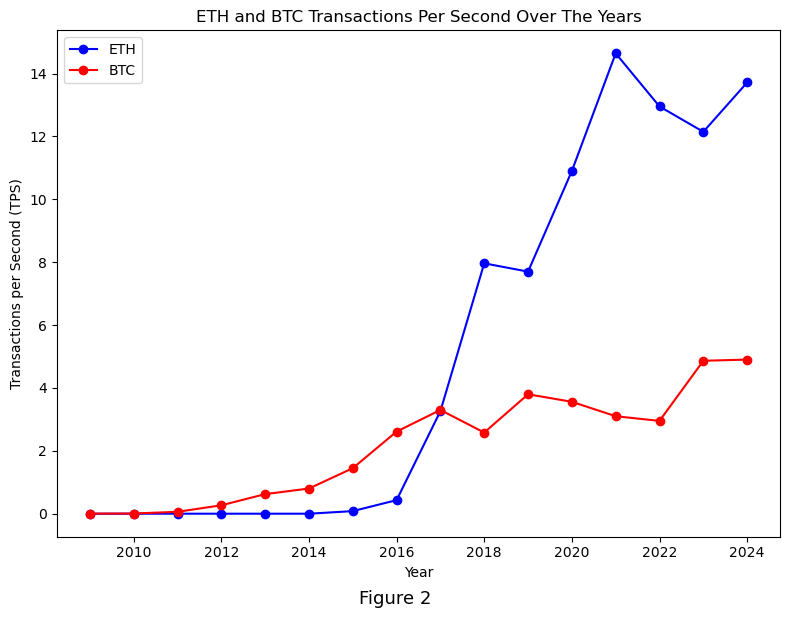

In [21]:
plot_multiple_line_graphs2(
    x_list=[[tps_trans["year"]]*2],
    y_list=[[[tps_trans["eth_transactions_per_sec"], "ETH", "b"], [tps_trans["btc_transactions_per_sec"], "BTC", "r"]]],
    x_labels=["Year"],
    y_labels=["Transactions per Second (TPS)"],
    titles=["ETH and BTC Transactions Per Second Over The Years"],
    formatter=[None],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=2
)

In Figure 2, we observe that Ethereum transactions are consistently faster than Bitcoin transactions. Ethereum reached a peak throughput of approximately 14 transactions per second (TPS) in 2021, while Bitcoin only managed around 4 TPS by 2024. This performance gap is largely expected, given the inherent differences in their block confirmation times. Bitcoin transactions typically take about 10 minutes to finalize due to its Proof of Work (PoW) consensus mechanism, which prioritizes security and decentralization over speed. In contrast, Ethereum, especially after its transition to Proof of Stake (PoS), has significantly faster block times—around 12 to 15 seconds—allowing for much higher throughput.

This difference highlights Ethereum’s advantage in scenarios requiring high-frequency transactions, such as decentralized applications and DeFi (Decentralized Finance) protocols, which depend on rapid execution. Bitcoin’s slower transaction speed, on the other hand, is more suited for large-value transfers where transaction frequency is less critical but security is paramount. Overall, in terms of transaction speed and throughput, Ethereum clearly outperforms Bitcoin, making it more adaptable for applications that demand high-volume and quick processing.

### BTC and ETCH Transaction Volume in USD using Coingecko Historical Prices

ETH and BTC daily prices are sourced from Coingecko website<sup>4</sup>. The prices are multiplied with the total transaction value over the years to get the Transaction volume in USD

In [23]:
volume = spark.sql(read_sql_file("sql/volume.sql")).toPandas().fillna(0)
volume

,year,eth_vol_usd,btc_vol_usd
0,2013,0.000000e+00,7.713772e+10
1,2014,0.000000e+00,1.340974e+11
2,2015,1.023266e+08,1.619858e+11
3,2016,6.897527e+09,5.564227e+11
4,2017,1.098248e+12,3.747492e+12
5,2018,7.668154e+11,3.389282e+12
6,2019,1.419953e+11,3.409980e+12
7,2020,3.133019e+11,6.449999e+12
8,2021,2.555531e+12,4.815111e+13
9,2022,1.353725e+12,3.898312e+13


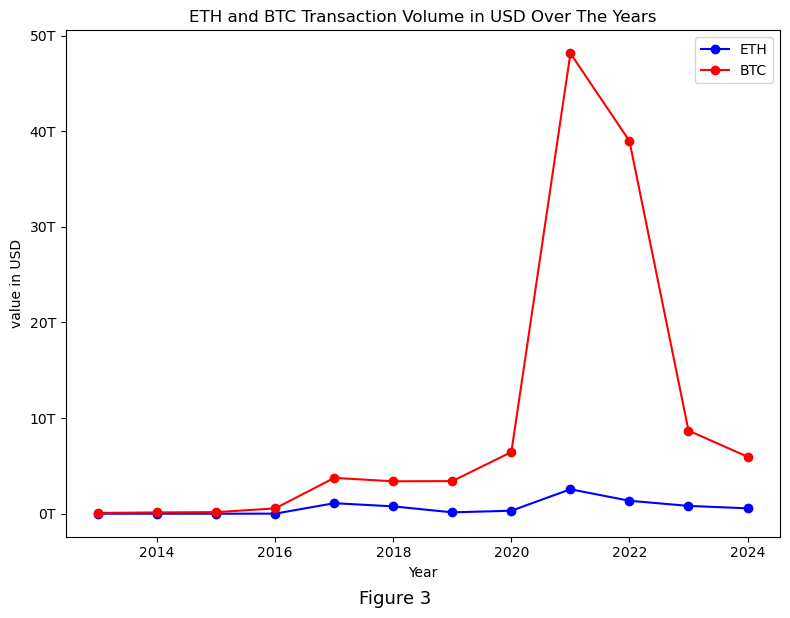

In [24]:
plot_multiple_line_graphs2(
    x_list=[[volume["year"]]*2],
    y_list=[[[volume["eth_vol_usd"], "ETH", "b"], [volume["btc_vol_usd"], "BTC", "r"]]],
    x_labels=["Year"],
    y_labels=["value in USD"],
    titles=["ETH and BTC Transaction Volume in USD Over The Years"],
    formatter=[trillions_formatter],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=3
)

In terms of transaction volume in USD, Bitcoin appears to dominate Ethereum, especially during key periods such as the pandemic years. Bitcoin’s transaction volume peaked at nearly 50 trillion USD in 2021, far surpassing Ethereum's transaction volume during the same period. This surge can be attributed to Bitcoin's established role as a store of value, with institutional investments and heightened retail interest driving massive transaction volumes as global economic uncertainty pushed investors toward digital assets. 

Bitcoin’s status as "digital gold" means it is often used for large-value transfers, making its total transaction volume higher despite having fewer transactions compared to Ethereum. Additionally, during market booms or periods of economic stress, Bitcoin experiences spikes in transaction volume as both a speculative asset and a hedge against traditional financial market instability.

Ethereum, while facilitating a broader range of use cases such as decentralized applications, DeFi, and NFTs, has a lower transaction volume in USD due to the smaller-scale, more frequent transactions typical of these applications. However, Ethereum’s volume is steadily growing as its ecosystem expands and gains mainstream adoption, although it has yet to match Bitcoin’s dominance in raw transaction value.

### Total Supply of Bitcoin and Ethereum Over The Years

In [25]:
btc_supply = spark.sql(read_sql_file("sql/btc_supply.sql")).toPandas()
btc_supply

,date,reward
0,2009-01-03,0.00
1,2009-01-09,700.00
2,2009-01-10,3750.00
3,2009-01-11,8400.00
4,2009-01-12,13100.00
...,...,...
5579,2024-04-18,19686493.75
5580,2024-04-19,19687437.50
5581,2024-04-20,19688250.00
5582,2024-04-21,19689125.00


In [26]:
eth_supply = spark.sql(read_sql_file("sql/eth_supply.sql")).toPandas()
eth_supply

,date,max_supply
0,2015-07-30,72034555
1,2015-07-31,72068870
2,2015-08-01,72095335
3,2015-08-02,72122125
4,2015-08-03,72148525
...,...,...
3190,2024-04-23,119094781
3191,2024-04-24,119094781
3192,2024-04-25,119094781
3193,2024-04-26,119094781


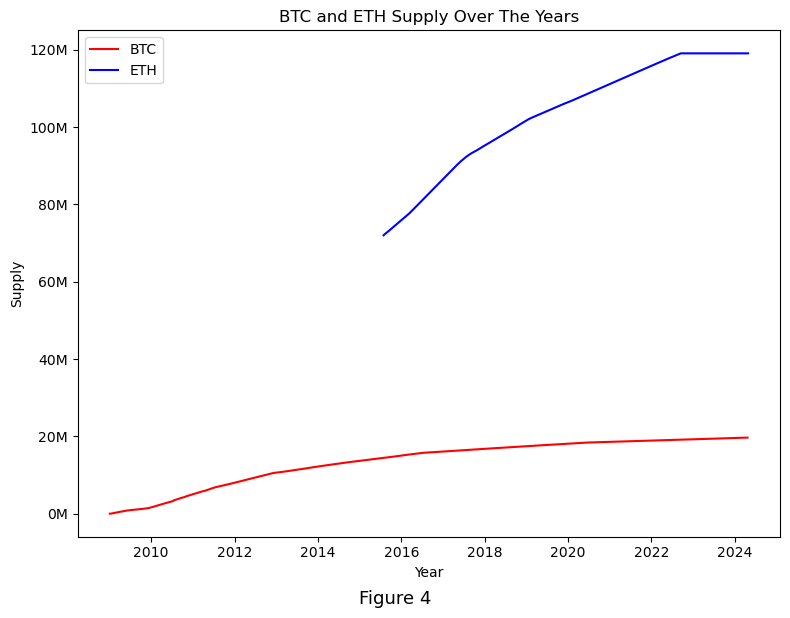

In [27]:
plot_multiple_line_graphs2(
    x_list=[[btc_supply["date"], eth_supply["date"]]],
    y_list=[
        [
            (btc_supply["reward"], "BTC", "r",),
            (eth_supply["max_supply"], "ETH", "b",),
        ]
    ],
    x_labels=["Year"],
    y_labels=["Supply"],
    titles=["BTC and ETH Supply Over The Years"],
    formatter=[millions_formatter],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=4,
    marker=None
)

Figure 4 illustrates the total supply of BTC and ETH. For Bitcoin, the maximum supply is capped at 21 million tokens. Additionally, Bitcoin undergoes a process known as reward halving, where the block reward for miners is reduced by half approximately every four years. This halving mechanism decreases the rate at which new bitcoins are created, increasing scarcity and potentially impacting price as the supply of new BTC decreases over time
    
For ETH it started with 72M tokens, In its initial phase, Ethereum rewarded miners with 5 ETH per block, which continued until block number 4,370,000. This marked the network's early stages, where a higher reward was necessary to incentivize miners and secure the network.

With the Byzantium upgrade, the block reward was reduced to 3 ETH per block, starting from block number 4,370,000 until block 7,280,000. This reduction was part of Ethereum’s roadmap to improve the efficiency of the network and gradually decrease inflation.

The Constantinople phase further reduced the block reward to 2 ETH per block, which remained in place from block number 7,280,000 to block 15,537,393. This consistent lowering of rewards was designed to make Ethereum's tokenomics more sustainable while continuing to incentivize miners.

Finally, with The Merge and the transition from Proof of Work (PoW) to Proof of Stake (PoS), Ethereum's block reward was effectively reduced to zero, as the mining process was replaced by staking. Stakers now validate transactions and secure the network, reflecting Ethereum's shift toward a more energy-efficient and scalable model.

### Network Value to Transactions (NVT) Ratio

In [28]:
daily_btc_amt = spark.sql("""
SELECT 
    TO_DATE(date) AS date, 
    SUM(input_value) AS total_value
FROM df_btc_trans
GROUP BY date
ORDER BY date
""").toPandas()
daily_btc_amt

,date,total_value
0,2009-01-03,NaN
1,2009-01-09,NaN
2,2009-01-10,NaN
3,2009-01-11,NaN
4,2009-01-12,NaN
...,...,...
5576,2024-04-21,478179.652565
5577,2024-04-22,694279.651478
5578,2024-04-23,734044.347663
5579,2024-04-24,785682.638285


In [29]:
daily_eth_amt = spark.sql("""
SELECT 
    TO_DATE(date) AS date, 
    SUM(value/1E18) AS total_value
FROM df_eth_trans
GROUP BY date
ORDER BY date
""").toPandas()
daily_eth_amt

,date,total_value
0,2015-08-07,2.008723e+06
1,2015-08-08,1.358322e+07
2,2015-08-09,1.165455e+06
3,2015-08-10,1.670911e+06
4,2015-08-11,1.485732e+06
...,...,...
3195,2024-05-06,9.837029e+05
3196,2024-05-07,1.148945e+06
3197,2024-05-08,9.972988e+05
3198,2024-05-09,9.711040e+05


In [30]:
spark.createDataFrame(daily_eth_amt).createOrReplaceTempView("daily_eth_amt")
spark.createDataFrame(daily_btc_amt).createOrReplaceTempView("daily_btc_amt")
spark.createDataFrame(eth_supply).createOrReplaceTempView("eth_supply")
spark.createDataFrame(btc_supply).createOrReplaceTempView("btc_supply")

In [31]:
nvt = spark.sql("""
SELECT
    a.date,
    d.reward/a.total_value as btc_nvt,
    c.max_supply/b.total_value as eth_nvt
FROM daily_btc_amt a
FULL OUTER JOIN daily_eth_amt b
    ON a.date = b.date
FULL OUTER JOIN eth_supply c
    ON a.date = c.date
FULL OUTER JOIN btc_supply d
    ON a.date = d.date
""").toPandas()

In [34]:
nvt['date'] = pd.to_datetime(nvt['date'])
_nvt = nvt[nvt['date'] > '2013-12-31']

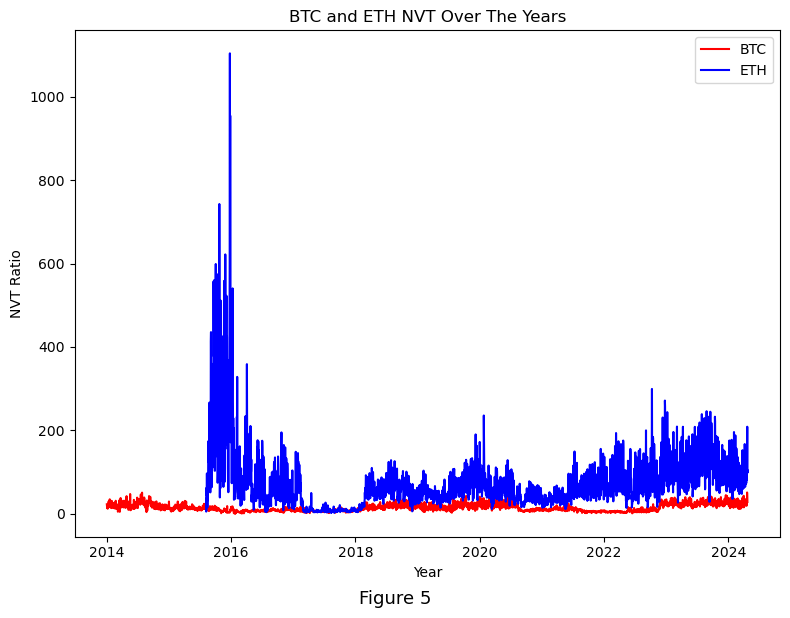

In [35]:
plot_multiple_line_graphs2(
    x_list=[[_nvt["date"], _nvt["date"]]],
    y_list=[
        [
            (_nvt["btc_nvt"], "BTC", "r",),
            (_nvt["eth_nvt"], "ETH", "b",),
        ]
    ],
    x_labels=["Year"],
    y_labels=["NVT Ratio"],
    titles=["BTC and ETH NVT Over The Years"],
    formatter=[None],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=5,
    marker=None
)

The Network Value to Transactions (NVT) Ratio is an important cryptocurrency metric that helps assess the valuation of a network, akin to the price-to-earnings (P/E) ratio used in traditional finance. It is calculated by dividing a cryptocurrency's market capitalization by its transaction volume over a specified period:

$$
\text{NVT Ratio} = \frac{\text{Market Capitalization}}{\text{Transaction Volume}}
$$

A high NVT ratio indicates that the market capitalization is growing faster than the transaction volume, which may suggest overvaluation or a decline in network utility. In contrast, a low NVT ratio could imply that a cryptocurrency is undervalued or experiencing increasing utility.

As illustrated in our analysis, Ethereum (ETH) displays a relatively high NVT ratio, signaling a potential overvaluation. This could reflect speculative interest in ETH driven by its role in the DeFi and NFT sectors, which has led to significant price appreciation. However, such a high ratio may also raise concerns about the sustainability of its current valuation if transaction volumes do not keep pace with market capitalization.

On the other hand, Bitcoin (BTC) exhibits a comparatively lower NVT ratio, suggesting that its valuation is more aligned with its utility as a digital currency and store of value. This lower ratio indicates that Bitcoin's network is actively facilitating a substantial volume of transactions relative to its market cap, signaling strong demand and utility. This dynamic positions Bitcoin as a potentially undervalued asset in the current market, especially as it continues to attract institutional investments and retail adoption.

Overall, the NVT ratio provides valuable insights into the relative valuations of ETH and BTC, helping investors gauge whether a cryptocurrency is priced appropriately given its transaction activity and utility.

## Conclusion

In conclusion, the comparison of BTC and ETH based on the following factors:

- Transaction validation proof and purpose
- Transaction count, total and average transaction value, and fees
- Throughput in TPS (transactions per second)
- Transaction volume in USD
- Total supply of BTC and ETH tokens
- Network Value to Transactions (NVT) ratio

shows that each token offers distinct strengths. BTC, often viewed as a store of value, emphasizes stability and security, while ETH, with its smart contract capabilities, supports a more versatile and innovative ecosystem. Ultimately, the choice between BTC and ETH depends on individual preferences—whether one prioritizes a robust decentralized currency or a platform driving blockchain innovation.

## References

<sup>1</sup> https://www.investopedia.com/articles/investing/031416/bitcoin-vs-ethereum-driven-different-purposes.asp \
<sup>2</sup> https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/eth.md \
<sup>3</sup> https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/btc.md \
<sup>4</sup> https://www.coingecko.com/